In [1]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from EarlyStopping import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMCoarseDataset, display_data_loader_batch

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 10
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

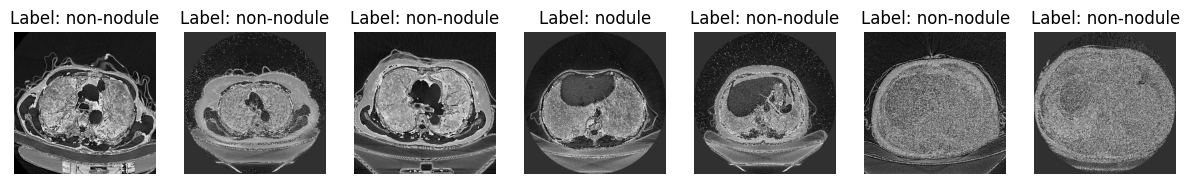

In [3]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),                      # Resize images to 224x224
    transforms.RandomHorizontalFlip(),                  # Data augmentation: random horizontal flip
    transforms.ToTensor(),                              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],         # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])         # Normalize using ImageNet std
])

test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),                      # Resize images to 224x224
    transforms.ToTensor(),                              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],         # Normalize using ImageNet mean
                         [0.229, 0.224, 0.225])         # Normalize using ImageNet std
])

# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes)
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_images(num_images=7)

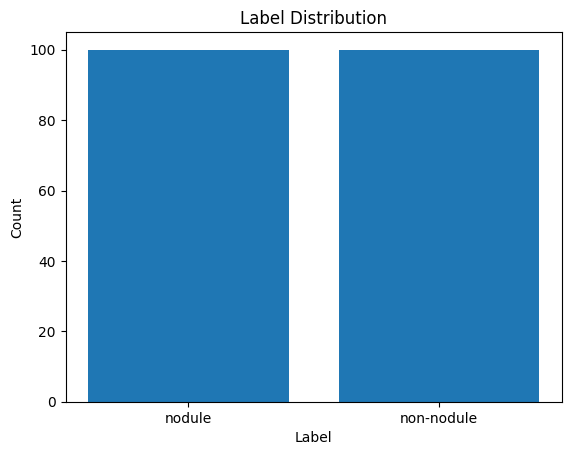

In [4]:
dataset.display_label_distribution()

In [5]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
model = TransferLearningModel(classes)
early_stopping = EarlyStopping(patience=2)
model.train(train_loader, early_stopping, epochs=30)

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Loss: 0.7553, Accuracy: 49.38%
Epoch 2/30
Loss: 0.6663, Accuracy: 63.75%
Epoch 3/30
Loss: 0.6180, Accuracy: 66.25%
Epoch 4/30
Loss: 0.6176, Accuracy: 66.25%
Epoch 5/30
Loss: 0.5543, Accuracy: 71.88%
Epoch 6/30
Loss: 0.5543, Accuracy: 73.75%
Epoch 7/30
Loss: 0.4906, Accuracy: 78.75%
Epoch 8/30
Loss: 0.5357, Accuracy: 71.88%
Epoch 9/30
Loss: 0.5305, Accuracy: 70.00%
Early stopping triggered


<Figure size 1000x800 with 0 Axes>

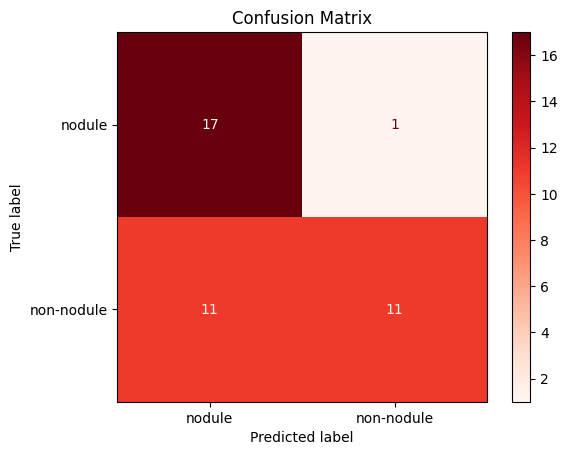

70.0

In [8]:
model.evaluate(test_loader)